In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
mlb_18=pyb.statcast('2018-03-29', '2018-10-01')

This is a large query, it may take a moment to complete


100%|██████████| 187/187 [02:58<00:00,  1.05it/s]


# RE

In [3]:
data = mlb_18.copy()
events = data[data['events'].notnull()]

In [4]:
def calculation(event):
    total_game = pd.DataFrame()
    game_id = np.array(event['game_pk'].unique())
    for i in game_id:
        game = event[event['game_pk']==i]
        # 타석 순으로 정리
        game = game.sort_values(by='at_bat_number')

        # Start에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['Start1'] = np.where(game['on_1b'].isnull(),0,1)
        game['Start2'] = np.where(game['on_2b'].isnull(),0,1)
        game['Start3'] = np.where(game['on_3b'].isnull(),0,1)

        # Start 주자 상황과 아웃카운트 병합
        game['Start_State'] = (game['Start1'].astype(str) + game['Start2'].astype(str) + game['Start3'].astype(str)+" " + game['outs_when_up'].astype(str))


        # End에서
        # 아웃카운트 계산 (이닝이 종료되었을 경우 3)
        game['end_out'] = game['outs_when_up'].shift(-1)
        game['end_out'] = np.where(game['end_out'].isnull(), 3, game['end_out'])
        game['end_out'] = np.where(((game['end_out']==0) & (game['outs_when_up']!=0)), 3, game['end_out'])

        # End에서
        # 1B, 2B, 3B에 주자가 없을 경우, 0으로
        # 1B, 2B, 3B가 주자가 있을 경우, 1으로
        game['end_1'] = game['Start1'].shift(-1)
        game['end_1'] = np.where((game['end_1'].isnull())|(game['end_out']==3), 0, game['end_1'])
        game['end_2'] = game['Start2'].shift(-1)
        game['end_2'] = np.where((game['end_2'].isnull())|(game['end_out']==3), 0, game['end_2'])
        game['end_3'] = game['Start3'].shift(-1)
        game['end_3'] = np.where((game['end_3'].isnull())|(game['end_out']==3), 0, game['end_3'])
        game[['end_1', 'end_2', 'end_3']]= game[['end_1', 'end_2', 'end_3']].astype('int')

        # End 주자 상황과 아웃카운트 병합
        game['End_State'] = (game['end_1'].astype(str) + game['end_2'].astype(str) + game['end_3'].astype(str)+" " + game['end_out'].astype(str))


        # 이닝당 득점한 점수 계산
        score = game.groupby(['inning', 'inning_topbot'])['bat_score'].max().reset_index().rename(columns={'bat_score': 'inning_score'})
        game = pd.merge(game, score, on=['inning', 'inning_topbot'])

        # 9회말 끝내기는 아웃카운트에 상관없이 경기가 끝나서 3아웃까지 채우지 않고도 경기가 끝나버린다.
        # 3아웃을 기준으로 측정한 run_expectancy에 영향이 가기 때문에 제외한다.
        if (game.iloc[-1]['inning_topbot']=='Bot') & (game.iloc[-1]['post_bat_score']>game.iloc[-1]['post_fld_score']):
            game.drop(game[(game['inning']==game['inning'].max()) & (game['inning_topbot']=='Bot')].index)

        # 현재 상황에서 이닝이 종료될때 까지의 득점 계산
        game['futureRun'] = game['inning_score'] - game['bat_score']


        # 모든 경기 데이터 병합
        total_game = pd.concat([total_game, game])

    return total_game

In [5]:
def run_value(df):
    start_RunExp = df.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'futureRun': 'Start_RE'})
    start_RunExp = start_RunExp.append({'Start_State': '000 3', 'Start_RE': 0}, ignore_index=True)
    end_RunExp = start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})

    df = pd.merge(df, start_RunExp, on=['Start_State'], how='left')
    df = pd.merge(df, end_RunExp, on=['End_State'], how='left')


    # Run Value: 타자의 득점 + (End State와 Start State의 득점 기대값 차이)
    # 1득점당 Run Value는 1로 계산
    # 득점 = post_bat_score - bat_score
    # 타석 후의 득점 기대값의 변화량 (End_RE - Start_RE)
    df['Start_RE'] = df['Start_RE'].astype('float32')
    df['End_RE'] = df['End_RE'].astype('float32')
    df['Run_Value'] = df['post_bat_score'] - df['bat_score'] + df['End_RE'] - df['Start_RE']
    
    return df

In [6]:
df_18 = calculation(events)
re_18 = run_value(df_18)

In [7]:
run_exp_18 = re_18.groupby(['Start_State'])['futureRun'].mean().reset_index().rename(columns={'Start_State':'State', 'futureRun':'RE'})
run_exp_18

,State,RE
0,000 0,0.486624
1,000 1,0.260734
2,000 2,0.09597
3,001 0,1.398693
4,001 1,0.975381
5,001 2,0.334115
6,010 0,1.106971
7,010 1,0.653822
8,010 2,0.305772
9,011 0,1.858995


# model

In [8]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [9]:
score = events[['game_pk', 'inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'home_score', 'away_score', 'post_home_score', 'post_away_score']]
max_score = score.groupby('game_pk').agg({'post_home_score': 'max', 'post_away_score': 'max'}).reset_index().rename(columns={'post_home_score': 'final_home', 'post_away_score': 'final_away'})

In [10]:
inning_score = score.groupby(['game_pk', 'inning', 'inning_topbot']).agg({'post_home_score': 'max', 'post_away_score': 'max'}).reset_index()
inning_score = inning_score.sort_values(by=['game_pk', 'inning', 'inning_topbot'],
                 ascending=[True, True, False])
inning_score = pd.merge(inning_score, max_score, on='game_pk')

inning_score['diff'] = (inning_score['post_home_score']-inning_score['post_away_score']).astype('int')

inning_score['result'] = np.where(inning_score['final_home']>inning_score['final_away'], 1, 0).astype('int')

final = inning_score.rename(columns={'post_home_score': 'home_score', 'post_away_score': 'away_score'})
final

,game_pk,inning,inning_topbot,home_score,away_score,final_home,final_away,diff,result
0,529406,1,Top,0,0,6,4,0,1
1,529406,1,Bot,0,0,6,4,0,1
2,529406,2,Top,0,3,6,4,-3,1
3,529406,2,Bot,0,3,6,4,-3,1
4,529406,3,Top,0,3,6,4,-3,1
...,...,...,...,...,...,...,...,...,...
43622,570335,7,Top,5,0,5,2,5,1
43623,570335,7,Bot,5,0,5,2,5,1
43624,570335,8,Top,5,0,5,2,5,1
43625,570335,8,Bot,5,0,5,2,5,1


In [11]:
home_win_prob = final['result'].mean()
home_win_prob

0.5161711783986981

In [12]:
beta0 = []
beta1 = []
for i in range(1,9):
    for j in ['Top', 'Bot']:
        logistic = smf.glm(formula='result ~ diff', data=final[(final['inning']==i)&(final['inning_topbot']==j)], family=sm.families.Binomial()).fit()
        beta0.append(logistic.params[0])
        beta1.append(logistic.params[1])

In [13]:
s0 = pd.DataFrame({'Half_Inning':[0], 'Beta0': [np.log(home_win_prob/(1-home_win_prob))], 'Beta1': None, 'inning': [0], 'inning_topbot': ['Bot']})
s1 = pd.DataFrame({'Half_Inning':np.arange(1,17), 'Beta0': beta0, 'Beta1': beta1})
s2 = pd.DataFrame({'Half_Inning':np.arange(17,51), 'Beta0': [s1['Beta0'].iloc[14], s1['Beta0'].iloc[15]]*17, 'Beta1': [s1['Beta1'].iloc[14], s1['Beta1'].iloc[15]]*17})
s3 = pd.concat([s1, s2])

In [14]:
from itertools import cycle
s3['inning'] = (s3['Half_Inning']+1)//2
top_bot = cycle(['Top', 'Bot'])
s3['inning_topbot'] = [next(top_bot) for num in range(len(s3))]

In [15]:
s = pd.concat([s0, s3])

# Win Probability

In [16]:
win_p = re_18.copy()
win_p['runs0'] = np.where(win_p['inning_topbot']=='Bot', win_p['home_score']-win_p['away_score']+win_p['Start_RE'], win_p['home_score']-win_p['away_score']-win_p['Start_RE'])
win_p['runs1'] = np.where(win_p['inning_topbot']=='Bot', win_p['post_home_score']-win_p['post_away_score']+win_p['End_RE'], win_p['post_home_score']-win_p['post_away_score']-win_p['End_RE'])
win_p = pd.merge(win_p, s[['inning', 'inning_topbot', 'Beta0', 'Beta1']], on=['inning', 'inning_topbot'])

In [17]:
def inv_log_odds(x):
    return np.exp(x)/(1+np.exp(x))

win_p['p_start'] = list(map(inv_log_odds, win_p['Beta0'] + (win_p['Beta1']*win_p['runs0'])))
win_p['p_end'] = list(map(inv_log_odds, win_p['Beta0'] + (win_p['Beta1']*win_p['runs1'])))
win_p['wpa'] = win_p['p_end'] - win_p['p_start']

In [18]:
wpa0 = win_p[['game_pk', 'game_date', 'player_name', 'pitch_name', 'batter', 'events', 'description', 'home_team', 'away_team',
       'inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'home_score', 'away_score', 'post_home_score', 'post_away_score',
      'Start_State', 'End_State', 'Start_RE', 'End_RE', 'Run_Value', 'runs0', 'runs1', 'Beta0', 'Beta1', 'p_start', 'p_end', 'wpa', 'delta_home_win_exp']]

last_event = wpa0.groupby('game_pk').tail(1)
last_event['p_end'] = np.where(last_event['post_home_score']>=last_event['post_away_score'],1,0)
last_event['wpa'] = last_event['p_end'] - last_event['p_start']

last_event_index = last_event.index
wpa1 = wpa0.loc[~wpa0.index.isin(last_event_index)]
wpa = pd.concat([wpa1, last_event]).sort_values(by=['game_date', 'game_pk', 'at_bat_number'])
wpa

,game_pk,game_date,player_name,pitch_name,batter,events,description,home_team,away_team,inning,inning_topbot,outs_when_up,at_bat_number,home_score,away_score,post_home_score,post_away_score,Start_State,End_State,Start_RE,End_RE,Run_Value,runs0,runs1,Beta0,Beta1,p_start,p_end,wpa,delta_home_win_exp
10346,529406,2018-03-29,"Archer, Chris",4-Seam Fastball,605141,field_out,hit_into_play,TB,BOS,1,Top,0,1,0,0,0,0,000 0,000 1,0.486624,0.260734,-0.22589,-0.486624,-0.260734,0.324733,0.455677,0.525725,0.551300,0.025575,0.022
10347,529406,2018-03-29,"Archer, Chris",Changeup,643217,field_out,hit_into_play,TB,BOS,1,Top,1,2,0,0,0,0,000 1,000 2,0.260734,0.095970,-0.164764,-0.260734,-0.09597,0.324733,0.455677,0.551300,0.569792,0.018492,0.015
10348,529406,2018-03-29,"Archer, Chris",Slider,434670,strikeout,swinging_strike,TB,BOS,1,Top,2,3,0,0,0,0,000 2,000 3,0.095970,0.000000,-0.09597,-0.09597,0.0,0.324733,0.455677,0.569792,0.580477,0.010686,0.01
20905,529406,2018-03-29,"Sale, Chris",4-Seam Fastball,622110,strikeout,swinging_strike,TB,BOS,1,Bot,0,4,0,0,0,0,000 0,000 1,0.486624,0.260734,-0.22589,0.486624,0.260734,0.075534,0.468361,0.575285,0.549253,-0.026033,-0.021
20906,529406,2018-03-29,"Sale, Chris",4-Seam Fastball,595281,strikeout,swinging_strike,TB,BOS,1,Bot,1,5,0,0,0,0,000 1,000 2,0.260734,0.095970,-0.164764,0.260734,0.09597,0.075534,0.468361,0.549253,0.530084,-0.019168,-0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165040,570335,2018-10-01,"Jansen, Kenley",Cutter,571448,home_run,hit_into_play,LAD,COL,9,Top,0,67,5,0,5,1,000 0,000 0,0.486624,0.486624,1.0,4.513376,3.513376,0.518957,1.123386,0.996276,0.988636,-0.007640,-0.008
165041,570335,2018-10-01,"Jansen, Kenley",Cutter,596115,home_run,hit_into_play,LAD,COL,9,Top,0,68,5,1,5,2,000 0,000 0,0.486624,0.486624,1.0,3.513376,2.513376,0.518957,1.123386,0.988636,0.965857,-0.022779,-0.018
165042,570335,2018-10-01,"Jansen, Kenley",Cutter,471865,field_out,hit_into_play,LAD,COL,9,Top,0,69,5,2,5,2,000 0,000 1,0.486624,0.260734,-0.22589,2.513376,2.739266,0.518957,1.123386,0.965857,0.973305,0.007448,0.018
165043,570335,2018-10-01,"Jansen, Kenley",Cutter,435622,strikeout,called_strike,LAD,COL,9,Top,1,70,5,2,5,2,000 1,000 2,0.260734,0.095970,-0.164764,2.739266,2.90403,0.518957,1.123386,0.973305,0.977715,0.004410,0.009


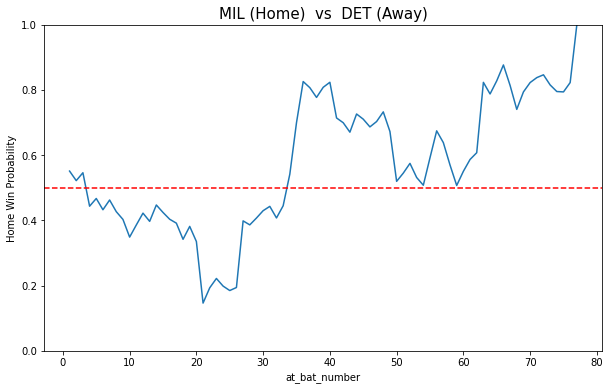

In [19]:
test = wpa[(wpa['game_pk']==531812)]

plt.figure(figsize=(10,6))
sns.lineplot(test['at_bat_number'], test['p_end'])
plt.axhline(0.5, color='red', linestyle='--')
plt.ylim(0,1)
plt.ylabel('Home Win Probability')
plt.title(test['home_team'].iloc[0]+' (Home)' +'  vs  '+ test['away_team'].iloc[0]+' (Away)', fontsize=15)
plt.show()

In [20]:
player_list = np.array(wpa['batter'])
player_data = pyb.playerid_reverse_lookup(player_list, key_type='mlbam')
player_data['batter_name'] = player_data['name_last'].str.title() + ', ' + player_data['name_first'].str.title()
player_name = player_data[['key_mlbam', 'batter_name']].rename(columns={'key_mlbam': 'batter'})
wpa = pd.merge(wpa, player_name, on='batter')

Gathering player lookup table. This may take a moment.


In [21]:
wpa['wpa_ab'] = np.abs(wpa['wpa'])
wpa_hr = wpa[wpa['events']=='home_run']
hr_comp = wpa_hr.groupby(['batter', 'batter_name']).agg({'game_pk': 'count', 'wpa_ab': 'mean'}).reset_index().rename(columns={'game_pk': 'count'})
hr_comp.sort_values(by='count', ascending=False)

,batter,batter_name,count,wpa_ab
132,501981,"Davis, Khris",48,0.166645
135,502110,"Martinez, J. D.",43,0.130669
409,608336,"Gallo, Joey",40,0.097761
407,608070,"Ramirez, Jose",39,0.126143
223,545361,"Trout, Mike",39,0.096084
...,...,...,...,...
462,624419,"Ciuffo, Nick",1,0.269983
461,624414,"Arroyo, Christian",1,0.063008
460,624407,"Lin, Tzu-Wei",1,0.172554
459,623993,"Santander, Anthony",1,0.392970


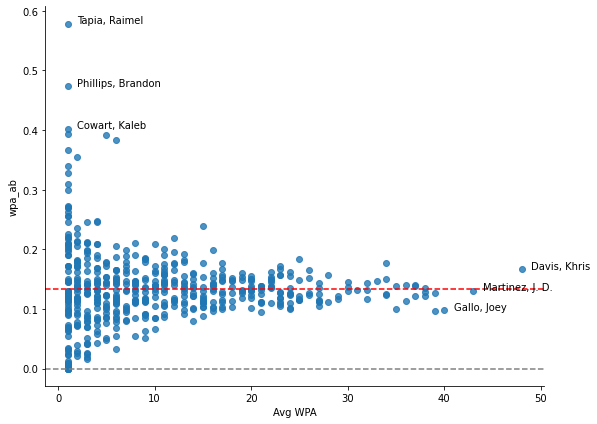

In [22]:
ax = sns.lmplot('count', 'wpa_ab', data=hr_comp, fit_reg=False, size=6, aspect=1.3)
plt.axhline(wpa_hr['wpa_ab'].mean(), color='red', linestyle='--')

count_top = hr_comp[hr_comp['count']>=40]
wpa_top = hr_comp[hr_comp['wpa_ab']>0.4]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+1, point['y'], str(point['val']))
        
label_point(count_top['count'], count_top['wpa_ab'], count_top['batter_name'], plt.gca())
label_point(wpa_top['count'], wpa_top['wpa_ab'], wpa_top['batter_name'], plt.gca())
plt.xlabel('Avg WPA')
plt.axhline(0, color='grey', linestyle='--')
plt.show()

In [23]:
wpa.groupby('Start_State')['wpa_ab'].mean()

Start_State
000 0    0.033478
000 1    0.024571
000 2    0.016529
001 0    0.035505
001 1    0.048421
001 2    0.045786
010 0    0.044087
010 1    0.046445
010 2    0.042980
011 0    0.051861
011 1    0.055865
011 2    0.067830
100 0    0.054151
100 1    0.045769
100 2    0.031744
101 0    0.057201
101 1    0.063833
101 2    0.061455
110 0    0.065278
110 1    0.067519
110 2    0.061477
111 0    0.075034
111 1    0.084149
111 2    0.104052
Name: wpa_ab, dtype: float64

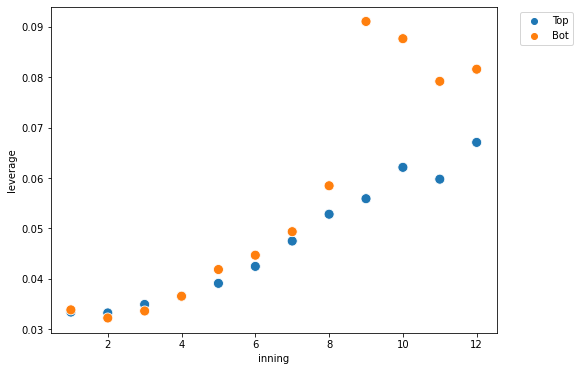

In [24]:
inning_leverage = wpa.groupby(['inning', 'inning_topbot'])['wpa_ab'].std().reset_index().sort_values(by=['inning', 'inning_topbot'], ascending=[True, False]).rename(columns={'wpa_ab': 'leverage'})
inning_12 = inning_leverage[inning_leverage['inning']<13]

plt.figure(figsize=(8,6))
sns.scatterplot('inning', 'leverage', hue='inning_topbot', data=inning_12, s=100)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='')
plt.show()

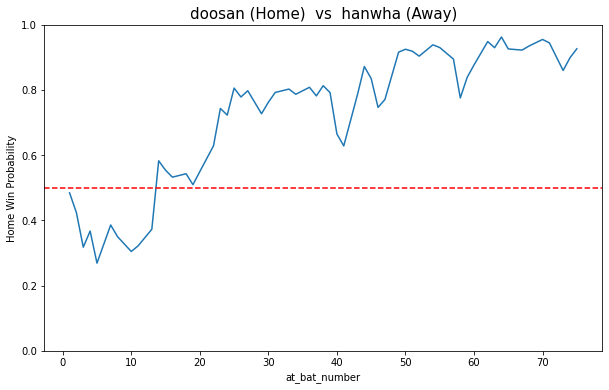

In [34]:
plt.figure(figsize=(10,6))
sns.lineplot(kbo['at_bat_number'], kbo['p_end'])
plt.axhline(0.5, color='red', linestyle='--')
plt.ylim(0,1)
plt.ylabel('Home Win Probability')
plt.title(kbo['home_team'].iloc[0]+' (Home)' +'  vs  '+ kbo['away_team'].iloc[0]+' (Away)', fontsize=15)
plt.show()